<a href="https://colab.research.google.com/github/afifamirul/MV-Related/blob/Midterm/1912995_Midterm_MV_SEM1_2324.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assessment / Midterm: Machine Vision and Deep Learning
<span style="color:blue">
    
1) Answer all questions
    
2) This assessment is open-book. You are allowed to refer to any references including online materials, books, notes, codes, github links, etc

3) Copy this notebook to your google drive (click **FILE** > **save a copy in Drive**)

4) Upload the **answer notebook & trained model** (for Question 3) to your github.

5) Submit the assessment by sharing the link to your github containing the answers.
    
</span>

**QUESTION 1 [15 marks]**

a) Let *k*, *s* and *p* be 4, 2 and 1, respectively. What will be the shape of the output of the convolutional layer? (2 marks)

>>import torch \
import torch.nn as nn \
input_img = torch.rand(1,3,10,10) \
layer = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=*k*, stride=*s*, padding=*p*)

<span style="color:blue">
    answer: The shape of the output is 12 x 5 x 5
</span>

b) Batch Normalization (BN) normalizes the mean and standard deviation for each: (tick X for the correct answer(s)) (2 marks)

 - [ ] Individual feature map
 - [/] X Instance in the mini-batch
 - [/] X Spatial dimension    

c) Which one of the following is not an advantage of Batch Normalization (BN)? (tick X for the correct answer(s)) (2 marks)

- [ ] BN accelerates the training of deep neural networks and tackles the vanishing gradient problem.
- [ ] For every input mini-batch, we calculate different statistics. This introduces some sort of regularization.
- [ ] BN reduces the dependence of gradients on the scale of the parameters or of their initial values.
- [/] X BN needs a much slower learning rate for the total architecture to converge.

d) Choose the correct statement. (tick X for the correct answer) (2 marks)

- [/] X A larger kernel is preferred for information that resides globally, and a smaller kernel is preferred for information that is distributed locally.
- [ ] A larger kernel is preferred for information that resides locally, and a smaller kernel is preferred for information that is distributed globally.

e) In the following network, how many learnable parameters (weights) are there? (2 marks)

In [ ]:
model = nn.Sequential(
        nn.Linear(3,20),
        nn.ReLU(),
        nn.Linear(20,2)
    )

<span style="color:blue">
    answer: There are 122  learnable parameters.
</span>

f) Which of the following statements are true about deep neural networks? (tick X for the correct answer) (2 marks)

- [/] X Deep neural networks usually require a big amount of data to be properly trained.
- [/] X They can be fooled by adversarial/ noisy examples.
- [ ] They are difficult to interpret and understand.
- [/] X They can still be subject to biases.
- [ ] They fail to understand the context of the data that they are handling.
- [ ] They perform very well on individual tasks but fail to generalize to many different tasks.

g) Run the code in the next cell.

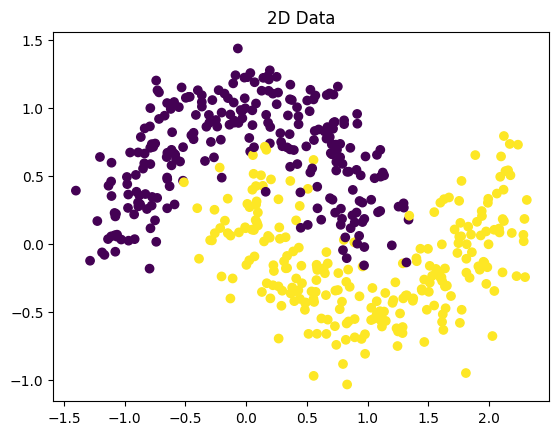

In [1]:
# import numpy as np
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
%matplotlib inline

# generate synthetic data in 2D
X, Y = make_moons(500, noise=0.2)

# plot the data
plt.scatter(X[:,0], X[:,1], c=Y)
plt.title('2D Data')
plt.show()

Can this data be correctly separable using the classifier below? Why? (3 marks)

model = nn.Sequential( \
    nn.Linear(n_input_dim, n_output), \
    nn.Sigmoid() \
    )
    
<span style="color:blue">
    answer: The data can be correctly separable using the classifier. In this code, we split the data into a training set and a testing set using the train_test_split function from sklearn.model_selection.Then, we train the logistic regression classifier on the training set. After training the classifier, we use it to make predictions on the testing set. Finally, we calculate the accuracy of the classifier by comparing its predictions with the true labels of the testing set. If the classifier can correctly separate the positive and negative classes, its accuracy should be 1.0, indicating that it has successfully learned the underlying pattern in the data.

</span>

**QUESTION 2 [40 marks]**

The COVID-19 pandemic continues to have a devastating effect on the health and well-being of the global population. A critical step in the fight against COVID-19 is effective screening of infected patients, with one of the key screening approaches being radiology examination using chest radiography. As a deep learning engineer, you are tasked to classify a dataset of X-ray images as either "normal", "covid" or "viral pneumonia". Use the chest X-ray dataset publicly available at https://www.kaggle.com/datasets/pranavraikokte/covid19-image-dataset to answer the following questions.


a) Create and train a ConvNet corresponding to the following architecture in Fig. 1 (with modifications of the input and final layers). Please include **(10 marks)**:

    1) The dataloader to load the train and test datasets.

    2) The model definition (either using sequential method OR pytorch class method).

    3) Define your training loop.

    4) Output the mean accuracy for the whole testing dataset.

![pic](https://raw.githubusercontent.com/CUTe-EmbeddedAI/images/main/images/LeNet.png)
    
                                Fig. 1: A convolutional neural network

In [ ]:
###############################################
###############YOUR CODES HERE ################
###############################################

In [10]:
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import glob
import numpy
import random

from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms

In [11]:
#if local
directory = "D:\IIUM\Semester\sem7\05 MV\MT\Covid19-dataset/"
#from googleDrive
from google.colab import drive
drive.mount('/content/gdrive')
dataset = '/content/gdrive/MyDrive/Machine Vision/Covid19-dataset/'


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [12]:
image_transforms = transforms.Compose(
    [transforms.Resize((32, 32)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batchSize = 8
#numClasses = len(os.listdir(directory+'train'))
numClasses = len(os.listdir(dataset+'/train'))

In [13]:
data = {
    'train' : datasets.ImageFolder(root=dataset+'train', transform = image_transforms),
    'test' : datasets.ImageFolder(root=dataset+'test', transform = image_transforms)
}

trainloader = DataLoader(data['train'], batch_size=batchSize, shuffle= True)
testloader = DataLoader(data['test'], batch_size=batchSize, shuffle= True)

train_data_size = len(data['train'])
test_data_size = len(data['test'])

In [14]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5, 1) #depth, outcome, kernal size
        self.pool = nn.MaxPool2d(2, 2)  #max pulling, nn2maxing
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = self.relu(self.fc1(x))
        #x = self.relu(self.fc2(x))
        x = self.fc2(x)
        #x = self.fc3(x)
        return x

In [15]:
model = CNN() # need to instantiate the network to be used in instance method

# 2. LOSS AND OPTIMIZER
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# 3. move the model to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=10, bias=True)
  (relu): ReLU()
)

In [16]:
import time # to calculate training time

def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)

    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''

    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))

        # Set to training mode
        model.train()

        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0

        valid_loss = 0.0
        valid_acc = 0.0

        for i, (inputs, labels) in enumerate(trainloader):

            inputs = inputs.to(device)
            labels = labels.to(device)

            # Clean existing gradients
            optimizer.zero_grad()

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            loss = loss_criterion(outputs, labels)

            # Backpropagate the gradients
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)

            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)

            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))


        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(testloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))

        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_test_loss = valid_loss/test_data_size
        avg_test_acc = valid_acc/test_data_size

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])

        epoch_end = time.time()

        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_test_loss, avg_test_acc*100, epoch_end-epoch_start))

        # Save if the model has best accuracy till now
        torch.save(model, 'cifar10_model_'+str(epoch)+'.pt')

    return model, history

In [17]:
num_epochs = 10
trained_model, history2 = train_and_validate(model, criterion, optimizer, num_epochs)

Epoch: 1/10
Epoch : 000, Training: Loss: 2.2985, Accuracy: 24.7012%, 
		Validation : Loss : 2.2419, Accuracy: 39.3939%, Time: 11.9842s
Epoch: 2/10
Epoch : 001, Training: Loss: 2.1701, Accuracy: 44.2231%, 
		Validation : Loss : 2.0934, Accuracy: 39.3939%, Time: 11.2842s
Epoch: 3/10
Epoch : 002, Training: Loss: 1.9203, Accuracy: 44.2231%, 
		Validation : Loss : 1.6325, Accuracy: 39.3939%, Time: 9.7394s
Epoch: 4/10
Epoch : 003, Training: Loss: 1.2080, Accuracy: 48.2072%, 
		Validation : Loss : 1.0071, Accuracy: 45.4545%, Time: 11.2606s
Epoch: 5/10
Epoch : 004, Training: Loss: 0.7960, Accuracy: 69.7211%, 
		Validation : Loss : 0.6946, Accuracy: 72.7273%, Time: 11.4959s
Epoch: 6/10
Epoch : 005, Training: Loss: 0.5994, Accuracy: 74.9004%, 
		Validation : Loss : 0.5815, Accuracy: 74.2424%, Time: 11.2044s
Epoch: 7/10
Epoch : 006, Training: Loss: 0.3980, Accuracy: 86.8526%, 
		Validation : Loss : 0.3864, Accuracy: 84.8485%, Time: 9.7411s
Epoch: 8/10
Epoch : 007, Training: Loss: 0.3574, Accuracy

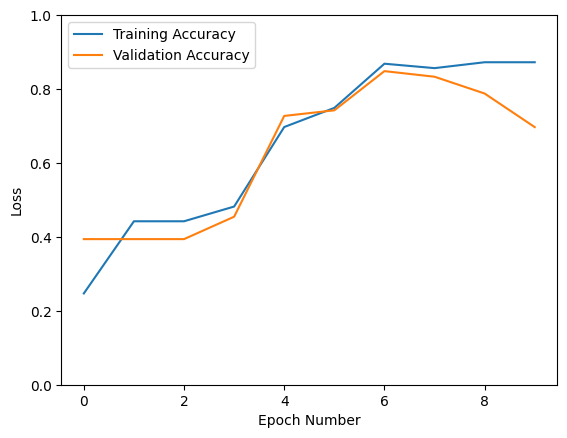

In [18]:
history2 = np.array(history2)
plt.plot(history2[:,2:4])
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,1)
# plt.savefig('cifar10_loss_curve.png')
plt.show()

b) Based on Question 2 a), answer the following questions:
    
    i) Is the model overfitting? Why? (4 marks)
   <font color='blue'>YES. Because the training data generally had good precision, the accuracy of the validation data decreased in the last epochs. Consider epoch 10, where the validation gives an accuracy of 69.6970%, but the training gives 87.2510% accuracy.</font>
    
    ii) Propose two methods to reduce the effect of overfitting. (4 marks)
   <font color='blue'>Two methods that I propose are: (1) Batch Normalization and Dropout (2) Data Augmentation <font>
   
    iii) Implement the two proposed methods in Q2 b) ii) in the next cell and show that the overfitting has been reduced. (8 marks)

In [ ]:
###############################################
###############YOUR CODES HERE ################
###############################################

In [31]:
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import glob
import numpy
import random

from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
#import torchvision.transforms as transforms
from torchvision import datasets, models, transforms

In [32]:
#if local
directory = "D:\IIUM\Semester\sem7\05 MV\MT\Covid19-dataset/"
#from googleDrive
from google.colab import drive
drive.mount('/content/gdrive')
dataset = '/content/gdrive/MyDrive/Machine Vision/Covid19-dataset/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [33]:
img_transform_aug = {
    'train' : transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.RandomPerspective(distortion_scale=0.6, p=1.0),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
      ]),

      'test' : transforms.Compose([
      transforms.Resize((32, 32)),
      transforms.CenterCrop(size=224),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
      ])

}
batchSize = 8
#numClasses = len(os.listdir(directory+'train'))
numClasses = len(os.listdir(dataset+'/train'))

In [34]:
image_transforms = transforms.Compose(
    [transforms.Resize((32, 32)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batchSize = 8
#numClasses = len(os.listdir(directory+'train'))
numClasses = len(os.listdir(dataset+'/train'))

In [35]:
numClasses

3

In [36]:
data = {
    'train' : datasets.ImageFolder(root=dataset+'train', transform = image_transforms),
    'test' : datasets.ImageFolder(root=dataset+'test', transform = image_transforms)
}

trainloader = DataLoader(data['train'], batch_size=batchSize, shuffle= True)
testloader = DataLoader(data['test'], batch_size=batchSize, shuffle= True)

train_data_size = len(data['train'])
test_data_size = len(data['test'])

In [37]:

print(str(train_data_size) + " / " + str(test_data_size)) #new len

251 / 66


In [38]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5, 1) #depth, outcome, kernal size
        self.pool = nn.MaxPool2d(2, 2)  #max pulling, nn2maxing
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 10)
        self.relu = nn.ReLU()
        self.batchnorm = nn.BatchNorm2d(6)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.batchnorm(x)
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = self.dropout(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [39]:
model = CNN() # need to instantiate the network to be used in instance method

# 2. LOSS AND OPTIMIZER
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# 3. move the model to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=10, bias=True)
  (relu): ReLU()
  (batchnorm): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [40]:
import time # to calculate training time

def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)

    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''

    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))

        # Set to training mode
        model.train()

        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0

        valid_loss = 0.0
        valid_acc = 0.0

        for i, (inputs, labels) in enumerate(trainloader):

            inputs = inputs.to(device)
            labels = labels.to(device)

            # Clean existing gradients
            optimizer.zero_grad()

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            loss = loss_criterion(outputs, labels)

            # Backpropagate the gradients
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)

            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)

            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))


        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(testloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))

        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_test_loss = valid_loss/test_data_size
        avg_test_acc = valid_acc/test_data_size

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])

        epoch_end = time.time()

        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_test_loss, avg_test_acc*100, epoch_end-epoch_start))

        # Save if the model has best accuracy till now
        torch.save(model, 'cifar10_model_'+str(epoch)+'.pt')

    return model, history

In [41]:
num_epochs = 10
trained_model, history3 = train_and_validate(model, criterion, optimizer, num_epochs)

Epoch: 1/10
Epoch : 000, Training: Loss: 2.0048, Accuracy: 27.0916%, 
		Validation : Loss : 1.6483, Accuracy: 68.1818%, Time: 11.8524s
Epoch: 2/10
Epoch : 001, Training: Loss: 1.0470, Accuracy: 65.3386%, 
		Validation : Loss : 0.8152, Accuracy: 60.6061%, Time: 11.7417s
Epoch: 3/10
Epoch : 002, Training: Loss: 0.6027, Accuracy: 78.8845%, 
		Validation : Loss : 0.5336, Accuracy: 80.3030%, Time: 10.6066s
Epoch: 4/10
Epoch : 003, Training: Loss: 0.4368, Accuracy: 86.4542%, 
		Validation : Loss : 0.4415, Accuracy: 81.8182%, Time: 12.0490s
Epoch: 5/10
Epoch : 004, Training: Loss: 0.4015, Accuracy: 84.4622%, 
		Validation : Loss : 0.4015, Accuracy: 86.3636%, Time: 11.9182s
Epoch: 6/10
Epoch : 005, Training: Loss: 0.2979, Accuracy: 90.8367%, 
		Validation : Loss : 0.4486, Accuracy: 80.3030%, Time: 11.8990s
Epoch: 7/10
Epoch : 006, Training: Loss: 0.3301, Accuracy: 88.8446%, 
		Validation : Loss : 0.3033, Accuracy: 90.9091%, Time: 11.3804s
Epoch: 8/10
Epoch : 007, Training: Loss: 0.2705, Accura

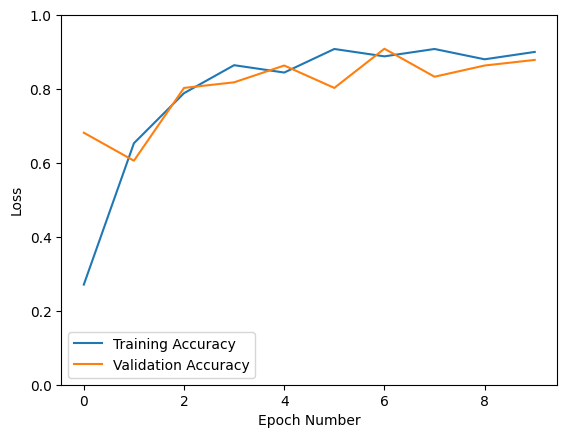

In [42]:
history3 = np.array(history3)
plt.plot(history3[:,2:4])
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,1)
# plt.savefig('cifar10_loss_curve.png')
plt.show()

c) Replace your defined ConvNet in b) with a pre-trained model. Then, proceed with a transfer learning and finetune the model for the COVID-19 dataset. **(10 marks)**

In [ ]:
###############################################
###############YOUR CODES HERE ################
###############################################

In [43]:
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import glob
import numpy
import random

from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
#import torchvision.transforms as transforms
from torchvision import datasets, models, transforms

In [44]:
image_transforms = transforms.Compose(
    [transforms.Resize((32, 32)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batchSize = 8
#numClasses = len(os.listdir(directory+'train'))
numClasses = len(os.listdir(dataset+'/train'))

In [45]:
data = {
    'train' : datasets.ImageFolder(root=dataset+'train', transform = image_transforms),
    'test' : datasets.ImageFolder(root=dataset+'test', transform = image_transforms)
}

trainloader = DataLoader(data['train'], batch_size=batchSize, shuffle= True)
testloader = DataLoader(data['test'], batch_size=batchSize, shuffle= True)

train_data_size = len(data['train'])
test_data_size = len(data['test'])

In [46]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5, 1) #depth, outcome, kernal size
        self.pool = nn.MaxPool2d(2, 2)  #max pulling, nn2maxing
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = self.relu(self.fc1(x))
        #x = self.relu(self.fc2(x))
        x = self.fc2(x)
        #x = self.fc3(x)
        return x

In [47]:
model = models.vgg16(pretrained=True)
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, 3)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 82.0MB/s]


In [48]:
#FineTuning
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum=0.9)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [49]:
import time # to calculate training time

def train_and_validate(model_ft, loss_criterion, optimizer_ft, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)

    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''

    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))

        # Set to training mode
        model.train()

        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0

        valid_loss = 0.0
        valid_acc = 0.0

        for i, (inputs, labels) in enumerate(trainloader):

            inputs = inputs.to(device)
            labels = labels.to(device)

            # Clean existing gradients
            optimizer.zero_grad()

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            loss = loss_criterion(outputs, labels)

            # Backpropagate the gradients
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)

            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)

            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))


        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(testloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))

        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_test_loss = valid_loss/test_data_size
        avg_test_acc = valid_acc/test_data_size

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])

        epoch_end = time.time()

        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_test_loss, avg_test_acc*100, epoch_end-epoch_start))

        # Save if the model has best accuracy till now
        torch.save(model, 'cifar10_model_'+str(epoch)+'.pt')

    return model, history

In [50]:
num_epochs = 10
trained_model, history4 = train_and_validate(model, criterion, optimizer, num_epochs)

Epoch: 1/10
Epoch : 000, Training: Loss: 0.9321, Accuracy: 57.3705%, 
		Validation : Loss : 0.9705, Accuracy: 40.9091%, Time: 14.2394s
Epoch: 2/10
Epoch : 001, Training: Loss: 0.6471, Accuracy: 77.6892%, 
		Validation : Loss : 0.6071, Accuracy: 74.2424%, Time: 13.2051s
Epoch: 3/10
Epoch : 002, Training: Loss: 0.4515, Accuracy: 82.4701%, 
		Validation : Loss : 0.7022, Accuracy: 69.6970%, Time: 13.0288s
Epoch: 4/10
Epoch : 003, Training: Loss: 0.2905, Accuracy: 91.6335%, 
		Validation : Loss : 0.3657, Accuracy: 87.8788%, Time: 13.2400s
Epoch: 5/10
Epoch : 004, Training: Loss: 0.2851, Accuracy: 92.4303%, 
		Validation : Loss : 0.2136, Accuracy: 90.9091%, Time: 13.1457s
Epoch: 6/10
Epoch : 005, Training: Loss: 0.1405, Accuracy: 95.6175%, 
		Validation : Loss : 0.2998, Accuracy: 90.9091%, Time: 13.2709s
Epoch: 7/10
Epoch : 006, Training: Loss: 0.0722, Accuracy: 97.6096%, 
		Validation : Loss : 0.2831, Accuracy: 89.3939%, Time: 13.1930s
Epoch: 8/10
Epoch : 007, Training: Loss: 0.1825, Accura

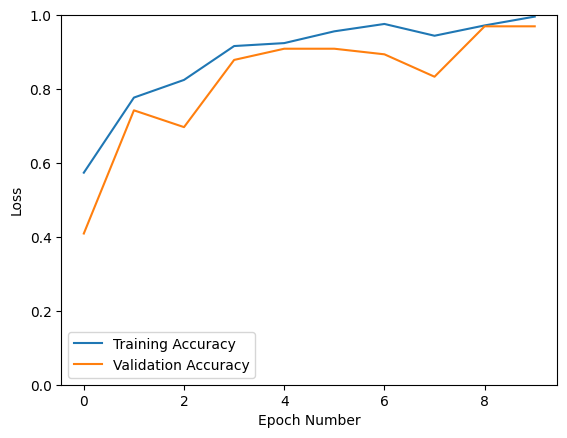

In [51]:
history4 = np.array(history4)
plt.plot(history4[:,2:4])
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,1)
# plt.savefig('cifar10_loss_curve.png')
plt.show()

d) Do you see any accuracy improvement? Whether it is a "yes" or "no", discuss the possible reasons contributing to the accuracy improvement/ unimprovement. **(4 marks)**

<span style="color:blue">
    Your answer here:
    Yes, by fine-tuning the network using the new VGG16 model, we are pretraining the data using its dataset, which contains 14 million more picture sources. In addition, the model includes more layers than before. It additionally improves precision. </span>

**QUESTION 3** **[15 marks]**

In a machine vision project, you decide to design a door access control system based on hand gestures. Only those who shows the correct hand gesture will be granted the access. There are three gestures that are recognized as correct access passcode which are "shaka", "peace" and "thumbs up", as depicted in Fig. 2.

![pic](https://simplyorganizedhi.com/media/catalog/product/1/6/169500.jpg)

                                Fig. 2 Shaka,peace, and thumbs up


Using the end-to-end object detection pipeline that you have learned, develop your own hand gesture detector so that it can be incorporate to a door access control system.

Deliverable for this question is the model .pt file. Change the name to <your_name>.pt file (e.g. hasan.pt).

- Marks are given based on the performance of the model when tested using my machine and camera at my office. This question aims to evaluate the model's robustness and generalization capabilities.